In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn
import json
import io
import requests
import pandas as pd
from pathlib import Path

In [2]:
### This is the local file path, but we decided to use an S3 bucket instead
# readpath = Path.cwd() / 'Data' / 'heart_failure_clinical_records_dataset.csv'
url="https://final-project-heart.s3.amazonaws.com/heart_failure_clinical_records_dataset.csv"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Formatting Dataset for Model with All Features

In [4]:
target = df["DEATH_EVENT"]
target_names = ["living", "deceased"]
data = df.drop("DEATH_EVENT", axis=1)
feature_names = data.columns
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=3)

### Formatting Dataset for Model with Patient Known Features

In [6]:
patient_known_data = df.drop(["time",
                              "creatinine_phosphokinase", 
                              "ejection_fraction", 
                              "platelets", 
                              "serum_creatinine", 
                              "serum_sodium", 
                              "DEATH_EVENT"], axis=1)
feature_names = patient_known_data.columns
patient_known_data.head()

,age,anaemia,diabetes,high_blood_pressure,sex,smoking
0,75.0,0,0,1,1,0
1,55.0,0,0,0,1,0
2,65.0,0,0,0,1,1
3,50.0,1,0,0,1,0
4,65.0,1,1,0,0,0


In [7]:
X_train_kd, X_test_kd, y_train_kd, y_test_kd = train_test_split(patient_known_data, target, test_size=0.20, random_state=4)

### Scale using MinMaxScaler
MinMaxScaler() is a sklearn.preprocessing class that allows the user to "Transform features by scaling each feature to a given range."

In [8]:
mm_scaler = StandardScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

mm_scaler_kd = StandardScaler()
mm_scaler_kd.fit(X_train_kd)
X_train_mm_kd = mm_scaler_kd.transform(X_train_kd)
X_test_mm_kd = mm_scaler_kd.transform(X_test_kd)

## All Features Data 

#### Create, Fit, Predict, and Score MLP Classifier with MinMaxScaler data

In [9]:
mlp_mm = MLPClassifier(hidden_layer_sizes=(16,8,4,4), activation='relu', solver='lbfgs', random_state=2, max_iter=2500)
mlp_mm.fit(X_train_mm, y_train)
predict_train_mm = mlp_mm.predict(X_train_mm)
predict_test_mm=mlp_mm.predict(X_test_mm)

In [10]:
predictions = mlp_mm.predict(X_test_mm)
report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
mlp_report = pd.DataFrame(report).T
mlp_report.to_html('./templates/MLP_Classifier_all_features_report.html')
mlp_report.to_csv('./Data/MLP_Classifier_all_features_report.csv')
print(confusion_matrix(y_train,predict_train_mm))
mlp_report.head()

[[162   1]
 [  0  76]]


,precision,recall,f1-score,support
living,0.911765,0.7750,0.837838,40.0
deceased,0.653846,0.8500,0.739130,20.0
accuracy,0.800000,0.8000,0.800000,0.8
macro avg,0.782805,0.8125,0.788484,60.0
weighted avg,0.825792,0.8000,0.804935,60.0


In [11]:
# train = []
# test = []
# for x in range(250,10050,50):
#     mlp_mm = MLPClassifier(hidden_layer_sizes=(4,4,4), activation='relu', solver='adam', random_state=2, max_iter=x)
#     mlp_mm.fit(X_train_mm, y_train)
#     train.append(mlp_mm.score(X_train, y_train))
#     test.append(mlp_mm.score(X_test, y_test))
#     print(f"Number of Iterations: {x+1}")

In [12]:
# plt.plot(train)
# plt.plot(test)

In [13]:
# train = []
# test = []
# it = 0
# for x in range(1,8):
#     for y in range(1,8):
#         for z in range(1,8):
#             mlp_mm = MLPClassifier(hidden_layer_sizes=(x,y,z), activation='relu', solver='adam', random_state=2, max_iter=2500)
#             mlp_mm.fit(X_train_mm, y_train)
#             train.append(mlp_mm.score(X_train, y_train))
#             test.append(mlp_mm.score(X_test, y_test))
#             it = it + 1
#             print(f"Iteration {it} - Hidden Layer Size: ({x},{y},{z})")

In [14]:
# plt.plot(train)

In [15]:
X_train_mm = X_train/X_train.max()
X_test_mm = X_test/X_test.max()


mlp_mm = MLPClassifier(hidden_layer_sizes=(16,8,4,8), activation='relu', solver='lbfgs', random_state=2, max_iter=2500)
mlp_mm.fit(X_train_mm, y_train)
mlp_mm.score(X_train_mm, y_train)
mlp_mm.score(X_test_mm,y_test)

predictions = mlp_mm.predict(X_test_mm)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions, target_names=target_names))

[[34  6]
 [ 4 16]]
              precision    recall  f1-score   support

      living       0.89      0.85      0.87        40
    deceased       0.73      0.80      0.76        20

    accuracy                           0.83        60
   macro avg       0.81      0.82      0.82        60
weighted avg       0.84      0.83      0.84        60



In [16]:
test = []


In [17]:
X_train_mm = X_train_kd/X_train_kd.max()
X_test_mm = X_test_kd/X_test_kd.max()
test2 = []
it = 0
for x in range(4,17,4):
    for y in range(4,17,4):
        test1 = [];
        for z in range(4,17,4):
            mlp_mm = MLPClassifier(hidden_layer_sizes=(x,y,z), activation='relu', solver='lbfgs', random_state=2, max_iter=2500)
            mlp_mm.fit(X_train_mm, y_train_kd)
            
            predict_train = mlp_mm.predict(X_train_mm)
            predict_test = mlp_mm.predict(X_test_mm)
            
            mlp_mm.score(X_train_mm, y_train_kd)
            mlp_mm.score(X_test_mm,y_test_kd)
            
            it = it + 1

            test = []
            test.append(it)
            test.append(x)
            test.append(y)
            test.append(z)
            test.append(mlp_mm.score(X_train_mm, y_train_kd))
            test.append(mlp_mm.score(X_test_mm,y_test_kd))
            test.append(confusion_matrix(y_train_kd,predict_train))
            test.append(confusion_matrix(y_test_kd,predict_test))
            test.append(classification_report(y_train_kd, predict_train, target_names=target_names, output_dict=True))
            test.append(classification_report(y_test_kd, predict_test, target_names=target_names, output_dict=True))

            test2.append(test)
            

C:\Users\Cam Foster\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cam Foster\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cam Foster\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cam Foster\anaconda3\lib\site-p

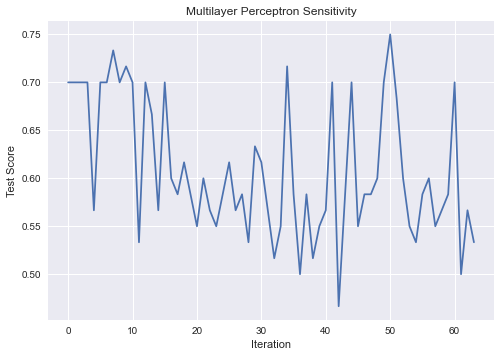

In [31]:
data = []
for x in range(64):
    data.append(test2[x][0:6])
    
df = pd.DataFrame(data=data)
df
fig1 = plt.plot(df[5])
plt.xlabel("Iteration")
plt.ylabel("Test Score")
plt.title("Multilayer Perceptron Sensitivity")
plt.style.use('seaborn')
plt.savefig("./Visuals/MLP_figure.png", dpi=1200)

## Patient Known Data

### Create, Fit, Predict, and Score MLP Classifier with MinMaxScaler data

In [105]:
mlp_mm_kd = MLPClassifier(hidden_layer_sizes=(16,8,4,4), activation='relu', solver='lbfgs', random_state=4, max_iter=2500)
mlp_mm_kd.fit(X_train_mm_kd, y_train_kd)
predict_train_mm_kd = mlp_mm_kd.predict(X_train_mm_kd)
predict_test_mm_kd=mlp_mm_kd.predict(X_test_mm_kd)

In [96]:
predictions = mlp_mm_kd.predict(X_test_mm_kd)
report = classification_report(y_test_kd, predictions, target_names=target_names, output_dict=True)
mlp_report = pd.DataFrame(report).T
mlp_report.to_html('./templates/MLP_Classifier_patient_known_features_report.html')
mlp_report.to_csv('./Data/MLP_Classifier_patient_known_features_report.csv')
print(confusion_matrix(y_train_kd,predict_train_mm_kd))
mlp_report.head()

[[152   9]
 [ 21  57]]


,precision,recall,f1-score,support
living,0.700000,0.833333,0.760870,42.000000
deceased,0.300000,0.166667,0.214286,18.000000
accuracy,0.633333,0.633333,0.633333,0.633333
macro avg,0.500000,0.500000,0.487578,60.000000
weighted avg,0.580000,0.633333,0.596894,60.000000


In [97]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=5)
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', random_state=5, max_iter=1000)
# mlp.fit(X_train, y_train)
# mlp.score(X_test, y_test)

In [19]:
# predict_train = mlp.predict(X_train)
# predict_test=mlp.predict(X_test)
# print(confusion_matrix(y_train,predict_train))
# predictions = mlp.predict(X_test)
# report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
# mlp_report = pd.DataFrame(report).T
# mlp_report.to_html('./templates/MLP_Classifier_patient_known_features_report.html')
# mlp_report.head()

### Scale using StandardScaler
StandardScaler() is a sklearn.preprocessing class that allows the user to "Standardize features by removing the mean and scaling to unit variance."

In [20]:
# whichScale = 1;
# if whichScale == 1:
#     std_scaler = StandardScaler()
#     std_scaler.fit(X_train)
#     X_train_std = std_scaler.transform(X_train)
#     X_test_std = std_scaler.transform(X_test)

#     std_scaler_kd = StandardScaler()
#     std_scaler_kd.fit(X_train_kd)
#     X_train_std_kd = std_scaler_kd.transform(X_train_kd)
#     X_test_std_kd = std_scaler_kd.transform(X_test_kd)

#### Create, Fit, Predict, and Score MLP Classifier with StandardScaler

In [21]:
# if whichScale == 1:
#     mlp_std = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', random_state=1, max_iter=2500)
#     mlp_std.fit(X_train_std, y_train)
#     predict_train_std = mlp_std.predict(X_train_std)
#     predict_test_std=mlp_std.predict(X_test_std)

In [22]:
# if whichScale == 1:
#     predictions = mlp_std.predict(X_test_std)
#     report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
#     mlp_report = pd.DataFrame(report).T
#     mlp_report.to_html('./templates/MLP_Classifier_all_features_report.html')
#     print(confusion_matrix(y_train,predict_train_std))
#     mlp_report.head()

#### Create, Fit, Predict, and Score MLP Classifier with StandardScaler data

In [23]:
# if whichScale == 1:
#     mlp_std_kd = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', random_state=3, max_iter=2500)
#     mlp_std_kd.fit(X_train_std_kd, y_train_kd)
#     predict_train_std_kd = mlp_std_kd.predict(X_train_std_kd)
#     predict_test_std_kd=mlp_std_kd.predict(X_test_std_kd)

In [24]:
# if whichScale == 1:
#     predictions = mlp_std_kd.predict(X_test_std_kd)
#     report = classification_report(y_test_kd, predictions, target_names=target_names, output_dict=True)
#     mlp_report = pd.DataFrame(report).T
#     mlp_report.to_html('./templates/MLP_Classifier_patient_known_features_StdScaler_report.html')
#     print(confusion_matrix(y_train_kd,predict_train_std_kd))
#     mlp_report.head()